# ADAPT-VQE

ADAPT-VQE was introduced by [Grimsley et al](https://www.nature.com/articles/s41467-019-10988-2) as a solution to the often impracticably deep, and not necessarily accurate, static VQE circuits. In ansatze like UCCSD, one easily reaches the order of thousands of gates, even for modestly sized molecules. In UCCSD and its generalized UCCGSD, the number of fermionic excitations in the ansatz scales like $\mathcal{O}(N^2M^2)$, and $\mathcal{O}(N^4)$ respectively. Here $N$ refers to the number of spin-orbitals in the problem basis, and $M$ the number of electrons.
.

In ADAPT-VQE, an ansatz which approximates not UCCSD/UCCGSD, but in fact FCI, is built iteratively. Over a series of cycles, the ansatz circuit is grown to achieve an approximation to FCI with a minimal number of circuit elements. In this way, ADAPT-VQE is a meta-VQE. At each step, a new ansatz is defined, and its parameters optimized according to conventional VQE. As the cycles proceed, the ansatz grows in both complexity and expressibility. This algorithm comes at the expense of a significant increase in measurement overhead. In order to identify the best operator to append to the present ansatz circuit, a large number of measurements are performed to rank the available operators in order of their ability to further reduce the ansatz state energy.

In this notebook, we'll explore the implementation of this algorithm, by using the implementation available in qSDK. 

ADAPT-VQE relies on three principal steps.

1. Use the UCCGSD pool $\{P_i\}$, a set of available operators from which we will iteratively construct the ansatz.
2. Rank operators by evaluating the gradient for each operator in the pool $\frac{\partial E^{(k)}}{\partial \theta_i} = \langle \psi_k|[H,P_i]|\psi_k\rangle$. Exit if the largest partial derivative is less than some cutoff or max iterations have been reached.
3. Append $U_k = \mathrm{exp}[i\theta_k P_k]$(index) to the ansatz $U=\prod_k U_k(\theta_k)$, and optimize $\langle H\rangle$ using VQE.
4. Return to step 2.

The UCCGSD pool allows for high accuracy with a small number of cycles and consequently very few variational parameters. However, the circuit remains very deep, as each excitation consists of many multi-qubit Pauli rotations. 

## Running the Adapt-VQE algorithm

We define a molecule $H_4$ in this case and use the `AdaptSolver` class to run Adapt-VQE.

In [2]:
from qsdk import SecondQuantizedMolecule
from qsdk.electronic_structure_solvers import ADAPTSolver

H4 = [("H", (0, 0, 0)), ("H", (0, 1.4, 0)), ("H", (0, 2.8, 0)), ("H", (0, 4.2, 0))]
mol = SecondQuantizedMolecule(H4, q=0, spin=0, basis="sto-3g", frozen_orbitals=[])

opt_dict = {"molecule": mol, "frozen_orbitals": None, "tol": 0.01, "max_cycles": 7, "verbose": False, "qubit_mapping": "jw"}

adapt_solver = ADAPTSolver(opt_dict)
adapt_solver.build()
adapt_solver.simulate()

Iteration 1 of ADAPT-VQE.
Iteration 2 of ADAPT-VQE.
Iteration 3 of ADAPT-VQE.
Iteration 4 of ADAPT-VQE.
Iteration 5 of ADAPT-VQE.
Iteration 6 of ADAPT-VQE.
Iteration 7 of ADAPT-VQE.


-2.028211284158737

After 7 cycles, we force the algorithm to terminate. 
We can now compare the results against the predictions of FCI.

Final Error: 8.5921E-04


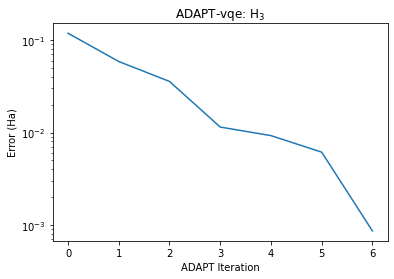

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from qsdk.electronic_structure_solvers.fci_solver import FCISolver

fci_solver = FCISolver(mol)
exact = fci_solver.simulate()
errors = np.array(adapt_solver.energies) - exact
fig,ax = plt.subplots(1,1)
ax.plot(errors)
ax.set_xlabel('ADAPT Iteration')
ax.set_ylabel('Error (Ha)')
ax.set_title('ADAPT-vqe: H$_3$')
ax.set_yscale('log')
print(f'Final Error: {errors[-1] :.4E}')

Ok, so after 7 cycles, we have an error of 0.9 mHa, within chemical accuracy of FCI. How does this all compare against UCCSD-VQE?

In [5]:
from qsdk.electronic_structure_solvers.vqe_solver import VQESolver, BuiltInAnsatze

vqe_solver = VQESolver({'molecule': mol, 'ansatz': BuiltInAnsatze.UCCSD})
vqe_solver.build()
vqe_solver.simulate()

converged SCF energy = -1.88779030448592
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.0281387578384398
            Iterations: 6
            Function evaluations: 97
            Gradient evaluations: 6


-2.0281387578384398

In [6]:
print(f'ADAPT-VQE ERROR: {adapt_solver.energies[-1] - exact :0.4E} Ha')
print(f'UCCSD-VQE ERROR: {vqe_solver.optimal_energy - exact :0.4E} Ha')

ADAPT-VQE ERROR: 8.5921E-04 Ha
UCCSD-VQE ERROR: 9.3174E-04 Ha


From the perspective of energy accuracy, the two have reached very similar results. The big advantage here however, are in the resources required for the Adapt-VQE ansatz circuit:

In [7]:
print(f'ADAPT RESOURCES:\n {adapt_solver.get_resources()}\n')
print(f'UCCSD RESOURCES:\n {vqe_solver.get_resources()}')

ADAPT RESOURCES:
 {'qubit_hamiltonian_terms': 185, 'circuit_width': 8, 'circuit_gates': 2308, 'circuit_2qubit_gates': 1152, 'circuit_var_gates': 128, 'vqe_variational_parameters': 7}

UCCSD RESOURCES:
 {'qubit_hamiltonian_terms': 185, 'circuit_width': 8, 'circuit_gates': 2692, 'circuit_2qubit_gates': 1312, 'circuit_var_gates': 160, 'vqe_variational_parameters': 14}


We have managed here to reduce the total number of variational parameters by a factor of two while keeping all the gate requirements similar. With ADAPT-VQE, the scaling of the number of parameters that need to be optimized should be better than the $\mathcal{O}(N^2M^2)$ scaling of UCCSD-VQE. 

There is another version of ADAPT-VQE which focuses on reducing the circuit depth instead of reducing the number of variational parameters. This is what we will explore next.

## Reducing circuit-depth with ADAPT-VQE

There are two obvious avenues along which one can be creative in the implementation of ADAPT-VQE--these are the selection of the operator pool $\{P_i\}$, and the ranking strategy. Above, we have specified that we are using the gradient to perform this ranking procedure. This is the only method which has been used previously, and we will continue to do so here. Regarding the choice of operator pool, the original method used the UCCGSD ansatz to generate the pool, i.e. the single, double fermionic excitations. Subsequent work has focused on qubit-native operators, and we'll follow this strategy as well. As we have showed above, the UCCGSD pool allows for high accuracy with a small number of cycles (and consequently very few variational parameters), but the circuit remains very deep. We will now show how to use a Hamiltonian-inspired qubit-pool to generate shorter circuits.

## Hamiltonian-Inspired Qubit-ADAPT
We are going to use the Hamiltonian to establish a set of pool generators to use in our implementation of ADAPT-VQE. For each term in the Hamiltonian which acts on a distinct combination of qubits, we'll add a pool operator which is guaranteed to have a non-zero commutator with respect to H, and therefore a finite gradient. This will give us a fairly compact set of operators in the pool, all of which are likely to be useful in our ansatz construction. To do this, we will scan through all terms in the qubit Hamiltonian. For each, we will identify the Pauli operators associated with electronic excitation (X and Y gates). We discard Z gates from the Pauli string. If the number of Y gates in a string is even, we can use this to construct an excitation pool element that preserves T-symmetry, by flipping one of the other X gates to a Y, or a Y to an X. Below, we'll flip the first X or Y to its partner.

In [8]:
def get_pool(qubit_hamiltonian, n_qubits):
    """Use Hamiltonian to identify non-commuting Pauli strings to use as operator pool.
    We identify terms with even number of Y-operators, in order to define excitations 
    which preserve T-reversal symmetry. We remove all Z operators, and we flip the first
    X or Y to its partner (i.e. X <> Y).
    Args:
        qubit_hamiltonian (QubitOperator): input Hamiltonian
        n_qubits (int): number of qubits for Hamiltonian
    
    Returns:
        pool_generators (list of QubitOperator): list of generators
    """
    import numpy as np
    from qsdk.toolboxes.operators.operators import QubitOperator

    pauli_lookup = {'Z':1, 'X':2, 'Y':3}
    pauli_reverse_lookup = ['I', 'Z', 'X', 'Y']
    pool_generators, pool_tuples = list(), list()
    indices = list()

    for term in qubit_hamiltonian.terms:
        pauli_string = np.zeros(n_qubits, dtype=int)
        
        #identify all X or Y factors
        for index, action in term:
            if pauli_lookup[action] > 1:
                pauli_string[index] = pauli_lookup[action]

        #only allow one operator acting on a given set of qubits
        action_mask = tuple(pauli_string > 1)
        if action_mask in indices:
            continue

        #only consider terms with even number of Y
        if sum(pauli_string) % 2 == 0 and sum(pauli_string) > 0:
            #identify qubit operator to change X<>Y
            flip_index = np.where(pauli_string > 1)[0][0]
            pauli_string[flip_index] += (-1)**(pauli_string[flip_index] % 2) 

            #update set of used qubit combinations
            indices.append(action_mask)
            #create QubitOperator for the new generator
            operator_tuple = tuple([(index,pauli_reverse_lookup[pauli]) for index, pauli in enumerate(pauli_string) if pauli > 0])
            #We don't use the coefficients directly, so since we need to multiply by 1.j for evaluating gradients, 
            #I'm just instantiating these with that coefficient in place
            pool_generators.append(QubitOperator(operator_tuple, 1.0j))
            pool_tuples.append(operator_tuple)
    
    return pool_generators

To exemplify the generation of an operator pool, we will apply this method to a simple Hamiltonian consisting of a single fermionic excitation and its Hermitian conjugate.

In [9]:
from qsdk.toolboxes.operators import QubitOperator
qubit_operator = QubitOperator(((0, 'X'), (1, 'X'), (2, 'Y'), (3, 'Y')), -1.0) \
                  + QubitOperator(((0, 'X'), (1, 'Y'), (2, 'Y'), (3, 'X')), 1.0) \
                  + QubitOperator(((0, 'Y'), (1, 'X'), (2, 'X'), (3, 'Y')), 1.0) \
                  + QubitOperator(((0, 'Y'), (1, 'Y'), (2, 'X'), (3, 'X')), -1.0) 
pool_generators = get_pool(qubit_operator, n_qubits=4)
print(f'OPERATOR POOL: {pool_generators}')

OPERATOR POOL: [1j [Y0 X1 Y2 Y3]]


We have used a qubit Hamiltonian where all operators act on the same qubit indices. This results in just a single generator pool element. As we traverse the `qubit_hamiltonian` in order, the generator corresponds to the first term in the Hamiltonian, with the first X operator switched to a Y operator. So from XXYY, we have YXYY. 

## Defining the problem
For the generator pool we've considered here, the smallest non-trivial problem to consider is H$_4$, as H$_2$ has only one generator and ADAPT terminates at FCI accuracy after a single iteration. So we'll apply the qubit-ADAPT algorithm to the same H$_4$ molecule as we did above with the UCCGSD pool. We obtain the qubit_operator using `fermion_to_qubit_mapping` to make use of the pool function defined above.

In [10]:
from qsdk.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping
from qsdk.toolboxes.operators import count_qubits

fermion_operator = mol._get_fermionic_hamiltonian()
qubit_operator = fermion_to_qubit_mapping(fermion_operator, 'jw', mol.n_active_sos, mol.n_electrons)
n_qubits = count_qubits(qubit_operator)

With the problem defined and the get_pool function prepared, we can proceed to initiate the ADAPT-VQE method. This is as simple as defining the problem with a options dictionary and initiating the `ADAPTSolver` class.

In [11]:
from qsdk.electronic_structure_solvers import ADAPTSolver

opt_dict = {"molecule": mol,
            "frozen_orbitals": 0,
            "pool": get_pool,
            "pool_args": (qubit_operator, n_qubits),
            "tol": 0.01,
            "max_cycles": 12,
            "verbose": False}

adapt_solver = ADAPTSolver(opt_dict)
adapt_solver.build()
adapt_solver.simulate()

After 12 cycles, we force the algorithm to terminate. We can now compare the results against the predictions of FCI.

Final Error: 1.4104E-03


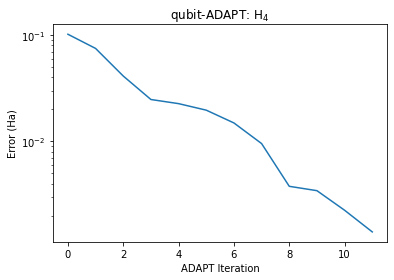

In [13]:
errors = np.array(adapt_solver.energies) - exact
fig,ax = plt.subplots(1,1)
ax.plot(errors)
ax.set_xlabel('ADAPT Iteration')
ax.set_ylabel('Error (Ha)')
ax.set_title('qubit-ADAPT: H$_4$')
ax.set_yscale('log')
print(f'Final Error: {errors[-1] :.4E}')

Ok so after 12 cycles, we have an error of 1.4 mHa, within chemical accuracy of FCI. How does this all compare against UCCSD-VQE?

In [14]:
print(f'ADAPT-VQE ERROR: {adapt_solver.energies[-1] - exact :0.4E} Ha')
print(f'UCCSD-VQE ERROR: {vqe_solver.optimal_energy - exact :0.4E} Ha')

ADAPT-VQE ERROR: 1.4104E-03 Ha
UCCSD-VQE ERROR: 9.3174E-04 Ha


From the perspective of energy accuracy, the two have reached very similar results, within a factor of two. The big advantage here however, are in the resources required for this ansatz circuit:

In [15]:
print(f'ADAPT RESOURCES:\n {adapt_solver.get_resources()}\n')
print(f'UCCSD RESOURCES:\n {vqe_solver.get_resources()}')

ADAPT RESOURCES:
 {'qubit_hamiltonian_terms': 185, 'circuit_width': 8, 'circuit_gates': 184, 'circuit_2qubit_gates': 72, 'circuit_var_gates': 12, 'vqe_variational_parameters': 12}

UCCSD RESOURCES:
 {'qubit_hamiltonian_terms': 185, 'circuit_width': 8, 'circuit_gates': 2692, 'circuit_2qubit_gates': 1312, 'circuit_var_gates': 160, 'vqe_variational_parameters': 14}



We have managed here to reduce the total number of gates by a factor of 10, the number of 2-qubit gates by a factor of nearly 15, and variational gates by a factor of 10. 

We note that this qubit-ADAPT-VQE has run with 2 fewer variational parameters than UCCSD-VQE. This is much closer to the UCCSD-VQE than the original ADAPT-VQE. Therefore, using these two variants of ADAPT-VQE, we have the opportunity to compromise between optimization complexity and ansatz expressivity by limiting the number of cycles. This flexibility in resource requirements is an important advantage for the ADAPT-VQE algorithm over static ansatze.

There is one small problem with a qubit inspired ansatz. It does not generally respect the symmetry of the problem. We can now examine the operators $\hat{S}^2$, $\hat{S}_Z$ and the $\hat{N}$ operators to determine if any loss of symmetry has occured. For this problem, the ground state is a singlet with 4 electrons in the system so the expected values are 0, 0, and 4 for $\hat{S}^2$, $\hat{S}_Z$ and $\hat{N}$ respectively.

In [23]:
exact_s2 = 0
exact_sz = 0
exact_n = mol.n_active_electrons
adapt_s2 = adapt_solver.vqe_solver.operator_expectation('S^2')
adapt_sz = adapt_solver.vqe_solver.operator_expectation('Sz')
adapt_n = adapt_solver.vqe_solver.operator_expectation('N')
uccsd_s2 = vqe_solver.operator_expectation('S^2')
uccsd_sz = vqe_solver.operator_expectation('Sz')
uccsd_n = vqe_solver.operator_expectation('N')

print(f'Adapt quantum numbers errors: N = {adapt_n-exact_n:6.4f}, Sz = {adapt_sz-exact_sz:6.4f}, S^2 = {adapt_s2-exact_s2:6.4f}')
print(f'UCCSD quantum numbers errors: N = {uccsd_n-exact_n:6.4f}, Sz = {uccsd_sz-exact_sz:6.4f}, S^2 = {uccsd_s2-exact_s2:6.4f}')

Adapt quantum numbers: N = 0.0001, Sz = 0.0004, S^2 = 0.0015
UCCSD quantum numbers: N = -0.0000, Sz = -0.0000, S^2 = 0.0000


As you can see, there are small errors in the desired quantum numbers with qubit-Adapt while UCCSD has the correct expectation values. Therefore, the resulting representation is not exactly what we wanted. To address this problem we can add a penalty term to the qubit hamiltonian and minimize this modified `qubit_hamiltonian` directly using Adapt-VQE instead of the molecular hamiltonian. Generating this new Hamiltonian is as simple as creating a dictionary of `[penalty_weight,  desired_quantum_number]` for each operator and using the `combined_penalty` function. For this example, we choose a `penalty_weight` of 1/2 for each term which is usually a reasonable choice.

In [26]:
from qsdk.toolboxes.ansatz_generator.penalty_terms import combined_penalty
from qsdk.toolboxes.operators.operators import qubitop_to_qubitham

# Define dictionary of desired quantum numbers [penalty_weight, desired_quantum_number]
penalty_weight = 1/2
dict_penalty_terms = {'N': [penalty_weight, exact_n],
                      'Sz': [penalty_weight, exact_sz],
                      'S^2': [penalty_weight, exact_s2]}

qubit_hamiltonian = qubitop_to_qubitham(qubit_operator, mapping='jw', up_then_down=False)
pen_qubit_operator = fermion_to_qubit_mapping(fermion_operator=combined_penalty(mol.n_active_mos,
                                                                                opt_penalty_terms=dict_penalty_terms),
                                              mapping='jw',
                                              n_spinorbitals=mol.n_active_sos,
                                              n_electrons=mol.n_electrons)
pen_qubit_hamiltonian = qubitop_to_qubitham(pen_qubit_operator, mapping='jw', up_then_down=False)
qubit_hamiltonian_with_pen = qubit_hamiltonian + pen_qubit_hamiltonian
opt_dict = {"qubit_hamiltonian": qubit_hamiltonian_with_pen,
            "n_electrons": mol.n_electrons,
            "n_spinorbitals": mol.n_active_sos, 
            "pool": get_pool,
            "pool_args": (qubit_hamiltonian_with_pen, n_qubits),
            "tol": 0.01,
            "max_cycles": 12,
            "verbose": False}

adapt_solver_with_pen = ADAPTSolver(opt_dict)
adapt_solver_with_pen.build()
adapt_solver_with_pen.simulate()

Iteration 1 of ADAPT-VQE.
Iteration 2 of ADAPT-VQE.
Iteration 3 of ADAPT-VQE.
Iteration 4 of ADAPT-VQE.
Iteration 5 of ADAPT-VQE.
Iteration 6 of ADAPT-VQE.
Iteration 7 of ADAPT-VQE.
Iteration 8 of ADAPT-VQE.
Iteration 9 of ADAPT-VQE.
Iteration 10 of ADAPT-VQE.
Iteration 11 of ADAPT-VQE.
Iteration 12 of ADAPT-VQE.


-2.0225993825889144

We can now check that minimizing this new Hamiltonian resulted in a state with the correct operator expectation values.

In [24]:
# Since we initialized VQESolver with a QubitHamiltonian, we need to provide the corresponding number of molecular
# orbitals to use the built-in operators S^2, Sz and N.
adapt_with_pen_s2 = adapt_solver_with_pen.vqe_solver.operator_expectation('S^2', n_active_mos=mol.n_active_mos)
adapt_with_pen_sz = adapt_solver_with_pen.vqe_solver.operator_expectation('Sz', n_active_mos=mol.n_active_mos)
adapt_with_pen_n = adapt_solver_with_pen.vqe_solver.operator_expectation('N', n_active_mos=mol.n_active_mos)

print(f'ADAPT-VQE ERROR: {adapt_solver_with_pen.vqe_solver.operator_expectation(qubit_operator) - exact :0.4E} Ha')
print(f'UCCSD-VQE ERROR: {vqe_solver.optimal_energy - exact :0.4E} Ha\n')
print(f'ADAPT RESOURCES:\n {adapt_solver_with_pen.get_resources()}')
print(f'UCCSD RESOURCES:\n {vqe_solver.get_resources()}\n')
print(f'Adapt quantum numbers: N = {adapt_with_pen_n - exact_n:6.4f}, Sz = {adapt_with_pen_sz - exact_sz:6.4f}, S^2 = {adapt_with_pen_s2 - exact_s2:6.4f}')
print(f'UCCSD quantum numbers: N = {uccsd_n - exact_n:6.4f}, Sz = {uccsd_sz - exact_sz:6.4f}, S^2 = {uccsd_s2 - exact_s2:6.4f}')

ADAPT-VQE ERROR: 6.4480E-03 Ha
UCCSD-VQE ERROR: 9.3174E-04 Ha

ADAPT RESOURCES:
 {'qubit_hamiltonian_terms': 695, 'circuit_width': 8, 'circuit_gates': 184, 'circuit_2qubit_gates': 72, 'circuit_var_gates': 12, 'vqe_variational_parameters': 12}
UCCSD RESOURCES:
 {'qubit_hamiltonian_terms': 185, 'circuit_width': 8, 'circuit_gates': 2692, 'circuit_2qubit_gates': 1312, 'circuit_var_gates': 160, 'vqe_variational_parameters': 14}

Adapt quantum numbers: N = -0.0000, Sz = -0.0000, S^2 = 0.0000
UCCSD quantum numbers: N = -0.0000, Sz = -0.0000, S^2 = 0.0000


As you can see, we have now found a state that has the correct symmetry properties but the resulting energy is now larger than chemical accuracy. Therefore, more cycles of ADAPT-VQE are needed if chemical accuracy is desired.

## Conclusion

In this notebook, we've explored an implementation of the original ADAPT-VQE algorithm, and the Hamiltonian-inspired qubit variant, using the tools available in qSDK. It is clear that the number of parameters required for accurate results can be made much smaller with the orignal algorithm, while the qubit version can reduce the circuit depth greatly. 